# Basic Chatbot
- This is a simple chatbot that answers basic questions
- It is also able to do basic tasks


In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

tavily_api_key = os.getenv('TAVILY_API_KEY')
load_dotenv()
hf_api_key = os.getenv('HUGGINGFACE_API_KEY')

In [2]:
from langchain_huggingface.llms import HuggingFaceEndpoint
from langchain_huggingface import ChatHuggingFace

from langchain_huggingface import HuggingFaceEmbeddings
import torch

embedding_model_name = 'sentence-transformers/all-MiniLM-L6-v2'
device = "cuda" if torch.cuda.is_available() else "cpu"

embedding_model = HuggingFaceEmbeddings(
model_name=embedding_model_name, model_kwargs={'device': device})
max_length = embedding_model._client.tokenizer.model_max_length - 50

llm_model_name = "mistralai/Mixtral-8x7B-Instruct-v0.1"
llm = HuggingFaceEndpoint(
    repo_id=llm_model_name,
    task="conversational",
    huggingfacehub_api_token = hf_api_key
)
chat_llm = ChatHuggingFace(llm=llm)

d:\RentalShop\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sample Output by the llm

In [3]:
from langchain_core.messages import HumanMessage, AIMessage

messages = [
    HumanMessage(content="Hello!"),
    AIMessage(content="Hi! How can I assist you?"),
    HumanMessage(content="Tell me about your services.")
]
print(chat_llm.invoke(messages))


content=' I am a large language model developed and run by Mistral AI. I am designed to help you with a wide range of natural language processing tasks such as:\n\n* Answering questions\n* Providing explanations on a topic\n* Writing assistance, such as generating text or proofreading\n* Summarizing content\n* Translating text into different languages\n* And much more!\n\nMy main goal is to provide high-quality and accurate responses that are useful to you. I can also learn from new information and feedback, helping me to improve over time. If you have any specific request or question, feel free to ask me!' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 135, 'prompt_tokens': 32, 'total_tokens': 167}, 'model_name': 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'system_fingerprint': '3.2.1-sha-4d28897', 'finish_reason': 'stop', 'logprobs': None} id='run--34cfe33a-060f-48ff-a808-6c7ccb4c7994-0' usage_metadata={'input_tokens': 32, 'output_tokens': 135, 'total_tokens

## Populating the database
- The following script populates the sqlite database for the vehicle information
- I have hard-coded vehicle information but a simple python block statment can allow the user to do the same : 
```python
    while True:
        again = input("Do you want to add a vehicle? (yes/no): ").strip().lower()
        if again != "yes":
            break
        vehicle_data = get_vehicle_data()
        add_vehicle(local_file,vehicle_data)
```
- I have also taken the liberty for manually writing the bookings.

### Populating Vehicle database

In [4]:
from datetime import date, datetime, timedelta

import sqlite3

import pandas as pd

In [5]:
sample_vehicles = [
    {
        'vehicle_id': 'SCORPIO001',
        'vehicle_name': 'Mahindra Scorpio',
        'vehicle_type': 'Car',
        'vehicle_wheel_count': 4,
        'vehicle_gear_type': '6-Speed Manual',
        'vehicle_price_per_day': 5000.0,
        'vehicle_price_per_hour': 500.0,
        'vehicle_description': 'Powerful SUV good for all types of terrain including hills and rough roads',
        'vehicle_mileage': 12.0,
        'vehicle_fuel_type': 'Diesel',
        'vehicle_transmission': 'Manual',
        'vehicle_seating_capacity': 7,
        'vehicle_user_rating': 4.5,
        'vehicle_usage': 2,
        'vehicle_user_feedback': 'Great for family trips and adventure rides'
    },
    {
        'vehicle_id': 'RE_CLASSIC_001',
        'vehicle_name': 'Royal Enfield Classic 350',
        'vehicle_type': 'Bike',
        'vehicle_wheel_count': 2,
        'vehicle_gear_type': '5-Speed Manual',
        'vehicle_price_per_day': 1500.0,
        'vehicle_price_per_hour': 100.0,
        'vehicle_description': 'Classic motorcycle good for long rides and heavy loads',
        'vehicle_mileage': 35.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Manual',
        'vehicle_seating_capacity': 2,
        'vehicle_user_rating': 4.2,
        'vehicle_usage': 8,
        'vehicle_user_feedback': 'Classic thumping sound and comfortable for long rides'
    },
    {
        'vehicle_id': 'ACTIVA_001',
        'vehicle_name': 'Honda Activa 6G',
        'vehicle_type': 'Scooty',
        'vehicle_wheel_count': 2,
        'vehicle_gear_type': 'Non-Gear',
        'vehicle_price_per_day': 800.0,
        'vehicle_price_per_hour': 60.0,
        'vehicle_description': 'Perfect for city rides and nearby locations',
        'vehicle_mileage': 50.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Automatic',
        'vehicle_seating_capacity': 2,
        'vehicle_user_rating': 4.3,
        'vehicle_usage': 90,
        'vehicle_user_feedback': 'Very fuel efficient and easy to ride'
    },
    {
        'vehicle_id': 'SWIFT_001',
        'vehicle_name': 'Maruti Swift',
        'vehicle_type': 'Car',
        'vehicle_wheel_count': 4,
        'vehicle_gear_type': '5-Speed Manual',
        'vehicle_price_per_day': 2500.0,
        'vehicle_price_per_hour': 200.0,
        'vehicle_description': 'Compact car perfect for city driving and small families',
        'vehicle_mileage': 22.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Manual',
        'vehicle_seating_capacity': 5,
        'vehicle_user_rating': 4.1,
        'vehicle_usage': 43,
        'vehicle_user_feedback': 'Good mileage and comfortable for city rides'
    },
    {
        'vehicle_id': 'PULSAR_001',
        'vehicle_name': 'Bajaj Pulsar 150',
        'vehicle_type': 'Bike',
        'vehicle_wheel_count': 2,
        'vehicle_gear_type': '5-Speed Manual',
        'vehicle_price_per_day': 1000.0,
        'vehicle_price_per_hour': 80.0,
        'vehicle_description': 'Sporty bike good for daily commuting and weekend rides',
        'vehicle_mileage': 45.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Manual',
        'vehicle_seating_capacity': 2,
        'vehicle_user_rating': 4.0,
        'vehicle_usage': 40,
        'vehicle_user_feedback': 'Good performance and stylish design'
    },
    {
        'vehicle_id': 'JUPITER_001',
        'vehicle_name': 'TVS Jupiter',
        'vehicle_type': 'Scooty',
        'vehicle_wheel_count': 2,
        'vehicle_gear_type': 'Non-Gear',
        'vehicle_price_per_day': 700.0,
        'vehicle_price_per_hour': 50.0,
        'vehicle_description': 'Reliable scooter with good storage space',
        'vehicle_mileage': 55.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Automatic',
        'vehicle_seating_capacity': 2,
        'vehicle_user_rating': 4.2,
        'vehicle_usage': 10,
        'vehicle_user_feedback': 'Excellent mileage and comfortable seat'
    }
]

In [6]:
local_file = "./db/vehicledb.sqlite"


def add_vehicle(file, vehicle_data):
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS vehicles (
        vehicle_id TEXT PRIMARY KEY,
        vehicle_name TEXT,
        vehicle_type TEXT,
        vehicle_wheel_count INTEGER,
        vehicle_gear_type TEXT,
        vehicle_price_per_day REAL,
        vehicle_price_per_hour REAL,
        vehicle_description TEXT,
        vehicle_mileage REAL,
        vehicle_fuel_type TEXT,
        vehicle_transmission TEXT,
        vehicle_seating_capacity INTEGER,
        vehicle_user_rating REAL,
        vehicle_usage REAL,
        vehicle_user_feedback TEXT
    )
""")
    columns = ', '.join(vehicle_data.keys())
    placeholders = ', '.join(['?'] * len(vehicle_data))
    values = tuple(vehicle_data.values())
    cursor.execute(
        f"INSERT OR IGNORE INTO vehicles ({columns}) VALUES ({placeholders})",
        values
    )
    conn.commit()
    conn.close()


for vehicle_data in sample_vehicles:
    add_vehicle(local_file, vehicle_data)

If a vehicle is new then the column for user rating and user feedback will be shown to user as none. This makes sure no misleading values are given keeping the data consistent. The user feedback is updated by sentiment analysis by the LLM.

Displays the existing vehicles in the db

In [7]:
from tabulate import tabulate

conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM vehicles", conn)
conn.close()

print(tabulate(df, headers='keys', tablefmt='psql'))  # or 'fancy_grid', 'grid'

+----+----------------+---------------------------+----------------+-----------------------+---------------------+-------------------------+--------------------------+----------------------------------------------------------------------------+-------------------+---------------------+------------------------+----------------------------+-----------------------+-----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | vehicle_id     | vehicle_name              | vehicle_type   |   vehicle_wheel_count | vehicle_gear_type   |   vehicle_price_per_day |   vehicle_price_per_hour | vehicle_description                                                        |   vehicle_mileage | vehicle_fuel_type   | vehicle_transmission   |   vehicle_seating_capacity |   vehicle_user_rating |   vehicle_usag

## Populating bookings

In [8]:
booking_data = [
    {
        "booking_id": "BKG_JSON_001",
        "customer_id": "CUST_J_001",
        "vehicle_id": "SCORPIO001",
        "booking_date": "2025-06-11",
        "start_date": "2025-06-15",
        "end_date": "2025-06-18",
        "booking_type": "Daily",
        "duration_value": 3,
        "duration_unit": "Days",
        "total_cost": 15000.00,
        "status": "Confirmed",
    },
    {
        "booking_id": "BKG_JSON_002",
        "customer_id": "CUST_J_002",
        "vehicle_id": "ACTIVA_001",
        "booking_date": "2025-06-11",
        "start_date": "2025-06-11",
        "end_date": "2025-06-11",
        "booking_type": "Hourly",
        "duration_value": 5,
        "duration_unit": "Hours",
        "total_cost": 300.00,
        "status": "Confirmed",
    }
]

In [9]:
local_file = "./db/vehicledb.sqlite"


def add_bookings(file, booking_data):
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS bookings (
        booking_id TEXT PRIMARY KEY,
        customer_id TEXT NOT NULL,
        vehicle_id TEXT NOT NULL,
        booking_date TEXT NOT NULL,
        start_date TEXT NOT NULL,
        end_date TEXT NOT NULL,
        booking_type TEXT NOT NULL,
        duration_value REAL NOT NULL,
        duration_unit TEXT NOT NULL,
        total_cost REAL NOT NULL,
        status TEXT NOT NULL,
        FOREIGN KEY (vehicle_id) REFERENCES vehicles(vehicle_id)
    )
    """)
    columns = ', '.join(booking_data.keys())
    placeholders = ', '.join(['?'] * len(booking_data))
    values = tuple(booking_data.values())
    cursor.execute(
        f"INSERT OR IGNORE INTO bookings ({columns}) VALUES ({placeholders})",
        values
    )
    conn.commit()
    conn.close()

for booking in booking_data:
    add_bookings(local_file, booking)

In [10]:
from tabulate import tabulate

conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM bookings", conn)
conn.close()

print(tabulate(df, headers='keys', tablefmt='psql')) 

+----+--------------+---------------+--------------+----------------+--------------+------------+----------------+------------------+-----------------+--------------+-----------+
|    | booking_id   | customer_id   | vehicle_id   | booking_date   | start_date   | end_date   | booking_type   |   duration_value | duration_unit   |   total_cost | status    |
|----+--------------+---------------+--------------+----------------+--------------+------------+----------------+------------------+-----------------+--------------+-----------|
|  0 | BKG_JSON_001 | CUST_J_001    | SCORPIO001   | 2025-06-11     | 2025-06-15   | 2025-06-18 | Daily          |                3 | Days            |        15000 | Confirmed |
|  1 | BKG_JSON_002 | CUST_J_002    | ACTIVA_001   | 2025-06-11     | 2025-06-11   | 2025-06-11 | Hourly         |                5 | Hours           |          300 | Confirmed |
+----+--------------+---------------+--------------+----------------+--------------+------------+--------

## Tools
- We define the tools of our chatbot
- These tools will help in vehicle recommendation, repairs, user feedback of the vehicle

### Vehicle Recommendation
- Based on the user's travel destination, travel budget, weather, the feedback on vehicle.
- I created a lookup text('.db/lookup_txt') which is stored in the vector store, for the llm to use it.
- The lookup_txt can be edited to further refine the recommendations.

Deleting collection named 'lookup_text' if it already exists. This will be the naem of the collection where I am storing embeddings from new collection.

In [11]:
import chromadb
from langchain_chroma import Chroma


db_path = os.path.join(os.getcwd(), "chroma_db")
try:
    chroma_client = chromadb.PersistentClient(path=db_path)
    chroma_client.delete_collection(name='lookup_ext')
except Exception as e:
    print(f"DB deletion error (ignored): {e}")

DB deletion error (ignored): Collection [lookup_ext] does not exists


Storing in vector store


In [12]:
import re

from langchain_core.tools import tool
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document


faq_text = 'db/vehicle_lookup.txt'
with open(faq_text, "r", encoding="utf-8") as file:
    faq_text = file.read()

# Split on lines that begin with a number followed by a dot (e.g., "1.")
raw_chunks = re.split(r"(?=\n\d+\.\s)", faq_text)
docs = [Document(page_content=txt.strip()) for txt in raw_chunks]


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100, chunk_overlap=30, length_function=len
)
split_docs = text_splitter.split_documents(docs)


# Create Chroma vector store
vector_store = Chroma.from_documents(
    split_docs,
    embedding=embedding_model,
    persist_directory=db_path,
    collection_name='lookup_text',
)
retriever = vector_store.as_retriever()

In [13]:
@tool
def lookup_recommendations(query: str) -> str:
    """See some suggestions of how to recommend vehicles."""
    try:
        docs = retriever.invoke(query, k = 1)
        if not docs:
            raise Exception("No recommendations found")
        return "\n\n".join([doc.page_content for doc in docs])
    except Exception as e:
        raise Exception(f"Error in lookup_recommendations: {str(e)}")

#### Sample output for the tool that uses the lookup document

In [14]:
print(lookup_recommendations("I am travelling on a budget and the place is far"))

* Recommend either a car or a touring bike with good mileage and comfort.


C:\Users\Samsung\AppData\Local\Temp\ipykernel_42232\109583940.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(lookup_recommendations("I am travelling on a budget and the place is far"))


In [15]:
def read_sql_query(sql,db):
    conn=sqlite3.connect(db)
    cur=conn.cursor()
    cur.execute(sql)
    rows=cur.fetchall()
    conn.commit()
    conn.close()
    for row in rows:
        print(row)
    return rows


@tool
def query_database(input_str: str) -> str:
    """Converts natural language questions to SQL queries and executes them."""
    try:
        # Parse input
        parts = input_str.split(";")
        if len(parts) != 3:
            raise Exception("Invalid input format. Please use: 'question;start_date;end_date'")
        
        question, start_date, end_date = parts

        # Validate dates if provided
        if start_date != "none" and end_date != "none":
            try:
                from datetime import datetime
                datetime.strptime(start_date, "%Y-%m-%d")
                datetime.strptime(end_date, "%Y-%m-%d")
            except ValueError:
                raise Exception("Invalid date format. Please use YYYY-MM-DD format.")

        prompt = f"""
        Given the following question about vehicle rentals, generate a SQL query to answer it.
        Question: {question}
        Start Date: {start_date}
        End Date: {end_date}
        
        Generate a SQL query that:
        1. Uses the vehicles table
        2. Considers the date range if provided
        3. Returns relevant information
        """
        
        sql_query = chat_llm.invoke(prompt)
        if not sql_query or not sql_query.content:
            raise Exception("Could not generate a valid SQL query")
        
        return sql_query.content
    except Exception as e:
        raise Exception(f"Error in query_database: {str(e)}")

#### Sample of how the sql query tool will function

In [16]:
result = query_database("Show available bikes;2025-06-11;2025-06-21")


In [17]:
print(result)

 To answer this question, I'm assuming you have a table named `vehicles` with the following columns: `id`, `type` (to differentiate between bikes, cars, etc.), `status` (to check if it's available or not), and `rental_start_date` and `rental_end_date` (to store rental information).

Here's a SQL query that meets the requirements:

```sql
SELECT id, type, status
FROM vehicles
WHERE status = 'available' 
AND (rental_start_date IS NULL OR rental_end_date IS NULL OR (rental_end_date < '2025-06-11'))
AND (rental_start_date > '2025-06-21' OR rental_start_date IS NULL);
```

This query filters vehicles based on the following conditions:

1. The vehicle's status should be 'available'.
2. The vehicle should either not have any rental information (both `rental_start_date` and `rental_end_date` are `NULL`), or the `rental_end_date` should be before the provided start date, or the `rental_start_date` should be after the provided end date. This ensures that only available vehicles during the specif

### Repair Help

In [18]:
MINOR_ISSUES = ["flat tire", "won't start", "headlight", "oil change", "brake squeak"]

def classify_issue(description: str) -> str:
    for issue in MINOR_ISSUES:
        if issue in description.lower():
            return "minor"
    return "major"


In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults


@tool
def vehicle_repair_assist(input_str: str) -> str:
    """Processes vehicle repair requests in format: "issue;destination;vehicle_name"."""
    try:
        # Parse input with safety checks
        parts = input_str.split(";")
        if len(parts) != 3:
            raise Exception("Invalid format. Please use: 'issue;destination;vehicle_name'")
        
        description, destination, vehicle_name = parts
        
        if not all([description, destination, vehicle_name]):
            raise Exception("Please provide all required information: issue, destination, and vehicle name")
        
        issue_type = classify_issue(description)

        if issue_type == "minor":
            search_results = TavilySearchResults(k=1).invoke(f'How to fix {description} . The vehicle is {vehicle_name}')
            return (
                f"This looks like a minor issue: {description}.\n"
                "You can try checking this guide:\n"
                f"{search_results}"
            )
        else:
            search_results = TavilySearchResults(k=3).invoke(f'Mechanics between Delhi and {destination} for fix')
            return (
                f"This might be a major issue: {description}.\n"
                "You can call us at +9199988822221, or find help nearby:\n"
                f"{search_results}"
            )
    except Exception as e:
        raise Exception(f"Error in vehicle_repair_assist: {str(e)}")

#### Sample output of the tool that provides breakdown assist

In [20]:
result = vehicle_repair_assist("The tyre has deflated;Jaipir;Scorpio")
print(result)


C:\Users\Samsung\AppData\Local\Temp\ipykernel_42232\1920203681.py:28: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_results = TavilySearchResults(k=3).invoke(f'Mechanics between Delhi and {destination} for fix')


This might be a major issue: The tyre has deflated.
You can call us at +9199988822221, or find help nearby:
[{'title': 'Instant car repair service in Delhi-NCR And Delhi Jaipur Expressway', 'url': 'https://roadmech24x7.com/instant-car-repair', 'content': "Have you ever encountered a traffic problem when you were in the middle of the road on your way to your office? Or are you just out on a family vacation and your engine won't start? The feeling is intense and will make you sink. Do not worry too much about it as the Road Mech 24x7 Mechanic service provides immediate mechanics who will attend to your vehicle problem [...] Road Mech 24x7 roadside help provider vendors are only a name away. We provide and guarantee super-speedy assistance via way of means of expert vehicle mechanics achieving out to motorist individuals in case of an automobile breakdown on road, everywhere in Delhi NCR, Jaipur and India. We try to be instant inside 20-half-hour with the answer-equipped team. Towing, ons

### Updating review and feedback for vehicle

In [21]:
from langchain_core.prompts import ChatPromptTemplate


def generate_updated_review(previous_review : str, new_review : str):
    prompt = ChatPromptTemplate.from_template(
    """
        You are a helpful assistant that combines and refines customer reviews. 
        The goal is to generate a new, well-written review that reflects both the previous and the updated feedback. 
        Preserve the tone, address both positive and negative points, and make it sound natural and honest.Try to fit in maximum 2 lines.

        Previous review: "{previous_review}"
        New review: "{new_review}"
        """
    )
    chain = prompt | chat_llm
    return chain.invoke({
        "previous_review": previous_review,
        "new_review": new_review
    }).content
    

In [22]:
@tool
def give_feedback(input_str: str) -> str:
    """Updates the rating and review of a vehicle based on vehicleId."""
    try:
        # Parse input
        parts = input_str.split(";", 2)
        if len(parts) != 3:
            raise Exception("Invalid input format. Please use: 'rating;review;vehicleId'")
        
        rating_str, review, vehicleId = parts
        
        # Validate rating
        try:
            rating = int(rating_str)
            if not 1 <= rating <= 5:
                raise Exception("Rating must be between 1 and 5")
        except ValueError:
            raise Exception("Invalid rating. Please provide a number between 1 and 5")

        # Validate vehicleId
        if not vehicleId or not vehicleId.strip():
            raise Exception("Invalid vehicle ID. Please provide a valid vehicle ID")

        conn = sqlite3.connect(local_file)
        cursor = conn.cursor()

        try:
            # Check if vehicle exists
            cursor.execute(
                "SELECT vehicle_user_rating, vehicle_usage, vehicle_user_feedback FROM vehicles WHERE vehicle_id = ?",
                (vehicleId,)
            )
            previous_data = cursor.fetchone()
            
            if not previous_data:
                raise Exception(f"No vehicle found with ID: {vehicleId}")

            old_rating, n, old_feedback = previous_data
            
            # Calculate new rating
            new_rating = (rating + old_rating * n) / (n + 1)
            new_feedback = generate_updated_review(old_feedback, review)
            
            # Update the database
            cursor.execute(
                """
                UPDATE vehicles
                SET vehicle_user_rating = ?, vehicle_usage = ?, vehicle_user_feedback = ?
                WHERE vehicle_id = ?
                """,
                (new_rating, n + 1, new_feedback, vehicleId)
            )
            conn.commit()
            return "Thank you for your feedback! It has been recorded successfully."
        except sqlite3.Error as e:
            raise Exception(f"Database error: {str(e)}")
        finally:
            conn.close()
    except Exception as e:
        raise Exception(f"Error in give_feedback: {str(e)}")



#### Sample for how the feedback tool works

In [23]:
conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM vehicles", conn)
conn.close()

print("Before : ")
print(tabulate(df, headers='keys', tablefmt='psql')) 

Before : 
+----+----------------+---------------------------+----------------+-----------------------+---------------------+-------------------------+--------------------------+----------------------------------------------------------------------------+-------------------+---------------------+------------------------+----------------------------+-----------------------+-----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | vehicle_id     | vehicle_name              | vehicle_type   |   vehicle_wheel_count | vehicle_gear_type   |   vehicle_price_per_day |   vehicle_price_per_hour | vehicle_description                                                        |   vehicle_mileage | vehicle_fuel_type   | vehicle_transmission   |   vehicle_seating_capacity |   vehicle_user_rating |   ve

In [24]:
give_feedback("5;The car is very god. I loved the experience;SCORPIO001")

'Thank you for your feedback! It has been recorded successfully.'

In [25]:
conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM vehicles", conn)
conn.close()

print("After : ")
print(tabulate(df, headers='keys', tablefmt='psql')) 

After : 
+----+----------------+---------------------------+----------------+-----------------------+---------------------+-------------------------+--------------------------+----------------------------------------------------------------------------+-------------------+---------------------+------------------------+----------------------------+-----------------------+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | vehicle_id     | vehicle_name              | vehicle_type   |   vehicle_wheel_count | vehicle_gear_type   |   vehicle_price_per_day |   vehicle_price_per_hour | vehicle_description                                                        |   vehicle_mileage |

### Updating review and feedback for chabot


In [26]:
from langchain.tools import tool
import sqlite3
from datetime import datetime

@tool
def store_chatbot_feedback(input_str: str) -> str:
    """Stores user feedback about the chatbot's performance."""
    try:
        # Split input into parts
        parts = input_str.split(';', 2)
        if len(parts) < 2:
            raise Exception("Invalid input format. Use: 'conversation_id;rating;feedback' with rating as a float")

        conversation_id = parts[0]
        try:
            rating = float(parts[1])
            if not 1 <= rating <= 5:
                raise Exception("Rating must be between 1 and 5")
        except ValueError:
            raise Exception("Invalid rating. Please provide a number between 1 and 5")

        feedback = parts[2] if len(parts) > 2 else ''

        conn = sqlite3.connect("db/vehicledb.sqlite")
        cursor = conn.cursor()

        try:
            # Create table if not exists
            cursor.execute(
                """
                CREATE TABLE IF NOT EXISTS chatbot_feedback (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    conversation_id TEXT NOT NULL,
                    rating REAL CHECK(rating >= 1 AND rating <= 5),
                    feedback TEXT,
                    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
                );
                """
            )

            # Insert feedback
            cursor.execute(
                """
                INSERT INTO chatbot_feedback (conversation_id, rating, feedback)
                VALUES (?, ?, ?)
                """,
                (conversation_id, rating, feedback)
            )
            conn.commit()
            return "Thanks for rating our chatbot! Your feedback helps us improve."
        except sqlite3.Error as e:
            raise Exception(f"Database error: {str(e)}")
        finally:
            conn.close()
    except Exception as e:
        raise Exception(f"Error in store_chatbot_feedback: {str(e)}")



In [27]:
store_chatbot_feedback("131;3")

'Thanks for rating our chatbot! Your feedback helps us improve.'

In [28]:
conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM chatbot_feedback", conn)
conn.close()

print("After : ")
print(tabulate(df, headers='keys', tablefmt='psql')) 

After : 
+----+------+-------------------+----------+--------------+---------------------+
|    |   id |   conversation_id |   rating | feedback     | timestamp           |
|----+------+-------------------+----------+--------------+---------------------|
|  0 |    1 |               121 |        5 |              | 2025-06-11 12:54:59 |
|  1 |    2 |               131 |        3 |              | 2025-06-11 13:04:16 |
|  2 |    3 |               131 |        3 |              | 2025-06-11 15:25:47 |
|  3 |    4 |               131 |        3 |              | 2025-06-11 15:35:01 |
|  4 |    5 |               131 |        3 |              | 2025-06-11 20:42:15 |
|  5 |    6 |             12345 |        4 | Good service | 2025-06-11 22:01:04 |
|  6 |    7 |               131 |        3 |              | 2025-06-12 00:13:40 |
|  7 |    8 |               131 |        3 |              | 2025-06-12 00:59:49 |
|  8 |    9 |               131 |        3 |              | 2025-06-12 01:08:57 |
+----+-

## Agent
- Next, defining the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.
- The assistant helps call the graph with state & config.

In [29]:

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, MessagesState, START, END
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages    




class State(TypedDict):
    messages: Annotated[list, add_messages]



prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a helpful and conversational customer support assistant for a Vehicle Rental Company located in Kashmiri Gate, Delhi.

Your job is to assist users with:
- Recommending rental vehicles.
- Answering queries using available tools.
- Helping with repair-related issues or feedback.

 Tool Usage Guidelines:
- Use tools like `lookup_recommendations`, `query_database`, `vehicle_repair_assist`, or `give_feedback` **only when the user asks a specific question that requires information or action.**
- Do **not** use any tools for casual greetings or small talk (e.g., "hello", "how are you").
- If a tool returns no results, try expanding the search intelligently before replying.
- If the user asks to speak to the rental company, give them the number `+9112233445566` and politely end the chat.

 Conversational Style:
- Be friendly, concise, and human-like.
- Responses should be around **30–40 tokens**.
- Remember and refer to earlier context naturally in replies.

Always close with:  
“How would you like to rate the chatbot today?”


    
Current conversation:"""),
    MessagesPlaceholder(variable_name="messages"),
])



tools = [
    lookup_recommendations,
    query_database,
    vehicle_repair_assist,
    give_feedback,
    store_chatbot_feedback
]


chat_llm_with_tools = chat_llm.bind_tools(tools)

def filter_chat_messages(messages):
    """
    Filters out only HumanMessage and AIMessage objects from the full message list.
    Useful for feeding into prompt templates that expect a chat history.
    """
    return [m for m in messages if isinstance(m, (HumanMessage, AIMessage))]


def agent_node(state: State):
        """The main agent that decides what to do next"""
        print(" Thinking...")
        
        # Format messages with prompt
        print("Tools available - using normal prompt")
        
        # Get the last message
        last_message = state["messages"][-1]
        
        # If the last message was a tool response, format it properly
        if hasattr(last_message, 'tool_calls'):
            # Only include the original user message
            formatted_messages = [
                {"role": "user", "content": state["messages"][0].content}
            ]
        else:
            # For normal conversation, include all messages except system messages
            formatted_messages = []
            for msg in state["messages"]:
                if isinstance(msg, dict):
                    if msg.get("role") != "system":
                        formatted_messages.append(msg)
                elif isinstance(msg, HumanMessage):
                    formatted_messages.append({"role": "user", "content": msg.content})
                elif isinstance(msg, AIMessage):
                    formatted_messages.append({"role": "assistant", "content": msg.content})
        
        # Add system message at the start
        formatted_messages.insert(0, {
            "role": "system",
            "content": """ are a helpful and conversational customer support assistant for a Vehicle Rental Company located in Kashmiri Gate, Delhi.

    Your job is to assist users with:
    - Recommending rental vehicles.
    - Answering queries using available tools.
    - Helping with repair-related issues or feedback.

    Tool Usage Guidelines:
    - Use tools like `lookup_recommendations`, `query_database`, `vehicle_repair_assist`, or `give_feedback` **only when the user asks a specific question that requires information or action.**
    - Do **not** use any tools for casual greetings or small talk (e.g., "hello", "how are you").
    - If a tool returns no results, try expanding the search intelligently before replying.
    - If the user asks to speak to the rental company, give them the number `+9112233445566` and politely end the chat.

    Conversational Style:
    - Be friendly, concise, and human-like.
    - Responses should be around **30–40 tokens**.
    - Remember and refer to earlier context naturally in replies."""
        })
        
        try:
            response = chat_llm.invoke(formatted_messages)
            print(f"AGENT RESPONSE: {response.content[:100]}...")

            if hasattr(response, 'tool_calls') and response.tool_calls:
                print(f"Tool call detected! ")
                try:
                    # Store the tool call in state to prevent loops
                    state['last_tool_call'] = response.tool_calls[0].get('id')
                    return {"messages": [response]}
                except Exception as tool_error:
                    print(f"Error in tool execution: {str(tool_error)}")
                    # Get the user's query from the last message
                    user_query = state["messages"][-1].content if isinstance(state["messages"][-1], HumanMessage) else state["messages"][-1]["content"]
                    
                    # Use Tavily search as fallback
                    search_results = TavilySearchResults(k=3).invoke(f"vehicle rental {user_query}")
                    
                    # Create a helpful response with the search results
                    error_response = AIMessage(content=(
                        "I'm having trouble processing your request directly, but I found some relevant information:\n\n"
                        f"{search_results}\n\n"
                        "Would you like to try asking your question in a different way?"
                    ))
                    return {"messages": [error_response]}
            
            return {"messages": [response]}
        except Exception as e:
            print(f"Error in agent_node: {str(e)}")
            try:
                # Get the user's query from the last message
                user_query = state["messages"][-1].content if isinstance(state["messages"][-1], HumanMessage) else state["messages"][-1]["content"]
                
                # Use Tavily search as fallback
                search_results = TavilySearchResults(k=3).invoke(f"vehicle rental {user_query}")
                print("yaay ",type(search_results))
                print("naay",search_results)
                # Create a helpful response with the search results
                error_response = AIMessage(content=(
                    "I'm having trouble processing your request directly, but I found some relevant information:\n\n"
                    f"{search_results}\n\n"
                    "Would you like to try asking your question in a different way?"
                ))
                return {"messages": [error_response]}
            except Exception as search_error:
                print(f"Error in fallback search: {str(search_error)}")
                # If even the fallback fails, return a basic error message
                return {"messages": [AIMessage(content="I apologize, but I'm having trouble processing your request right now. Please try again in a moment.")]}



def should_continue(state: State) -> Literal["tools", "end"]:
    """Determine if we should use tools or end the conversation"""
    last_message = state["messages"][-1]
    current_count = state.get('tool_call_count', 0)
    # If the last message has tool calls, use tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print("ROUTING: Going to tools")
        return "tools"
    else:
        print("ROUTING: Ending conversation")
        return "end"

In [30]:
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import uuid

tool_node = ToolNode(tools)

# Build the custom graph
def create_custom_agent():
    # Initialize the graph
    workflow = StateGraph(State)
    
    # Add nodes
    workflow.add_node("agent", agent_node)
    workflow.add_node("tools", tool_node)
    
    # Add edges
    workflow.add_edge(START, "agent")  # Start with agent
    
    # Add conditional edge from agent
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {
            "tools": "tools",
            "end": END
        }
    )
    
    # After tools, always go back to agent
    workflow.add_edge("tools", "agent")
    
    return workflow


workflow = create_custom_agent()
memory = MemorySaver()
agent_graph = workflow.compile(checkpointer=memory)

# Test with tool call limiting
config = {"configurable": {"thread_id": str(uuid.uuid4())}}


Displaying the general flow of the graph. Since all the operations are **read-only**, I did not add any conditions to access the tools.


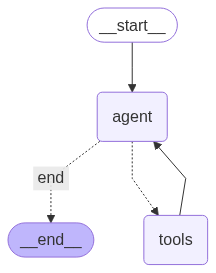

In [31]:
from IPython.display import Image, display

try:
    display(Image(agent_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Example Conversations

In [32]:
import uuid

user_questions = [
    "Hello",
    #  Before Renting - Vehicle Search & Comparison
    "Which cars are automatic and seat at least 5 people?",

    # Before Renting - Availability & Booking
    "Is the Mahindra Scorpio available this weekend?",

    # During Renting - Issues
    "The vehicle is making noise, what should I do?",

    "I want a stylish vehicle for a short city visit."
]

for question in user_questions:
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    agent_graph.update_state(config, {"messages": []})
    for step in agent_graph.stream(
       {"messages":[HumanMessage(content=question)]},
        config,
        stream_mode="values",
    ):
        print(f"📝 Current messages count: {len(step['messages'])}")
        step["messages"][-1].pretty_print()
        print("-" * 30)
    agent_graph.update_state(config, {"messages": []})

    

📝 Current messages count: 1
================================ Human Message =================================

Hello
------------------------------
 Thinking...
Tools available - using normal prompt
AGENT RESPONSE:  Hello! I'm here to help you with any questions you have about our vehicle rental services in Kashmi...
ROUTING: Ending conversation
📝 Current messages count: 2
================================== Ai Message ==================================

 Hello! I'm here to help you with any questions you have about our vehicle rental services in Kashmiri Gate, Delhi. Whether you need a recommendation for a rental vehicle or have a repair-related issue, I'm here to assist. Just let me know what you need. 

If you'd like to speak directly with the rental company, you can reach them at +9112233445566.
------------------------------
ROUTING: Ending conversation
📝 Current messages count: 1
================================ Human Message =================================

Which cars are automa